<a href="https://colab.research.google.com/github/aidanjmaldonado/penny-stock-lstm/blob/main/penny_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import sqlite3
import requests
import sys








In [11]:
# Download database from github repository
historical_url = "https://raw.githubusercontent.com/CSE-115-UCSC/penny-stock-lstm/main/historicaldata.db"
scrape_request = requests.get(historical_url)

try:
  # Contingent on request status
  scrape_request = requests.get(historical_url)
  scrape_request.raise_for_status()

  # Create local database from pull, name 'historicaldata.db'
  with open("historical.db", "wb") as db_file:
    db_file.write(scrape_request.content)

  print("Request to download database succeeded")


except:
  # Report failed request status
  sys.stderr.write("Request to download database failed")

Request to download database succeeded


In [12]:
# Connect to SQlite database
try:
  db = 'historical.db'
  sqliteConnection = sqlite3.connect(db)
  cursor = sqliteConnection.cursor()
  print(f'SQlite connected with {db}')

except:
  sys.stderr.write("Failed to connect to database")

SQlite connected with historical.db


In [13]:
# Gather User Input for Query
# ticker = input("Enter ticker symbol: ")
ticker = "IAG"

In [14]:
# Query {ticker(s)} from Database
try:
  query = f"SELECT * FROM all_historical WHERE ticker = '{ticker}';"
  cursor.execute(query)
  if cursor.fetchone() is None:
    raise Exception("No results")
  print(f"Success querying {ticker}")

except:
  sys.stderr.write(f"Failed to select {ticker}")

Success querying IAG


In [16]:
# Turn SQlite Database into Pandas Dataframe
data = pd.read_sql_query(query, sqliteConnection)
print(data.shape)

# Features
features = np.array(data.columns)
print(features)

# Using the column 'time' (millisecond) add a new column 'dates' with datetime
data['dates'] = pd.to_datetime(data['time'], unit='ms')

# Display Head
data.head()

(21230, 10)
['id' 'ticker' 'volume' 'volume_weighted_average' 'open' 'close' 'high'
 'low' 'time' 'number_of_trades']


,id,ticker,volume,volume_weighted_average,open,close,high,low,time,number_of_trades,dates
0,146894,IAG,184929,1.4695,1.475,1.460,1.4750,1.46,1657643400000,196,2022-07-12 16:30:00
1,146895,IAG,95464,1.4598,1.465,1.465,1.4650,1.45,1657643700000,80,2022-07-12 16:35:00
2,146896,IAG,12896,1.4610,1.465,1.465,1.4699,1.46,1657644000000,22,2022-07-12 16:40:00
3,146897,IAG,29196,1.4590,1.460,1.450,1.4600,1.45,1657644300000,29,2022-07-12 16:45:00
4,146898,IAG,21968,1.4564,1.455,1.455,1.4600,1.45,1657644600000,22,2022-07-12 16:50:00


In [17]:
features = data[['volume', 'volume_weighted_average', 'open', 'close', 'high', 'low']].values


In [ ]:

# Select features to use
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        xs.append(data[i:i + sequence_length])
        ys.append(data[i + sequence_length, 3])  # Index 3 for the 'close' price
    return np.array(xs), np.array(ys)

sequence_length = 10  # Number of time steps you want to use in sequences
x, y = create_sequences(scaled_features, sequence_length)

# Split data into train and test sets
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
model.evaluate(x_test, y_test)

Epoch 1/100
478/478 [==============================] - 13s 19ms/step - loss: 0.0033 - val_loss: 9.1546e-05
Epoch 2/100
478/478 [==============================] - 6s 14ms/step - loss: 0.0015 - val_loss: 1.4848e-04
Epoch 3/100
478/478 [==============================] - 8s 16ms/step - loss: 9.9706e-04 - val_loss: 5.9936e-05
Epoch 4/100
478/478 [==============================] - 6s 13ms/step - loss: 7.3805e-04 - val_loss: 7.3878e-05
Epoch 5/100
478/478 [==============================] - 8s 16ms/step - loss: 5.7528e-04 - val_loss: 5.4530e-05
Epoch 6/100
478/478 [==============================] - 6s 14ms/step - loss: 5.1623e-04 - val_loss: 6.1263e-05
Epoch 7/100
478/478 [==============================] - 8s 16ms/step - loss: 4.9541e-04 - val_loss: 7.0786e-05
Epoch 8/100
478/478 [==============================] - 7s 14ms/step - loss: 4.7899e-04 - val_loss: 5.2170e-05
Epoch 9/100
478/478 [==============================] - 8s 16ms/step - loss: 4.6312e-04 - val_loss: 6.3767e-05
Epoch 10/100
478/

6.324494461296126e-05

In [ ]:
print(features[0:,])

[[5.50760e+04 1.30370e+00 1.31500e+00 1.29500e+00 1.32000e+00 1.29470e+00]
 [1.43647e+05 1.30300e+00 1.29950e+00 1.31500e+00 1.31500e+00 1.29500e+00]
 [4.19990e+04 1.31300e+00 1.31500e+00 1.31500e+00 1.32000e+00 1.31000e+00]
 ...
 [2.80000e+02 1.11000e+00 1.11000e+00 1.11000e+00 1.11000e+00 1.11000e+00]
 [2.50000e+02 1.12000e+00 1.12000e+00 1.12000e+00 1.12000e+00 1.12000e+00]
 [9.00000e+02 1.12000e+00 1.12000e+00 1.12000e+00 1.12000e+00 1.12000e+00]]


133/133 [==============================] - 2s 5ms/step
[[0.46370545]
 [0.46346548]
 [0.4646117 ]
 ...
 [0.81602716]
 [0.81368786]
 [0.81386787]]


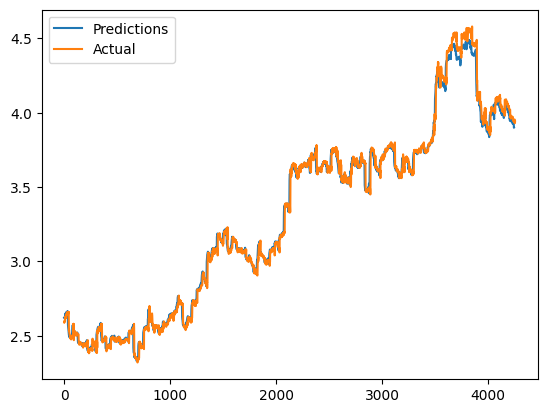

In [ ]:
predictions = model.predict(x_test)
#predictions = scaler.inverse_transform(np.concatenate((x_test[:, -1, 1:], predictions), axis=1))[:, -1]

# Plot predictions
import matplotlib.pyplot as plt
m_scaler = MinMaxScaler()
print(predictions)
m_scaler.min_, m_scaler.scale_ = scaler.min_[3], scaler.scale_[3]
plt.plot(m_scaler.inverse_transform(predictions), label='Predictions')
plt.plot(features[:, 3][train_size:], label='Actual')
plt.legend()
plt.show()